In [1]:
pip install zarr-eosdis-store pqdm cartopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from eosdis_store import EosdisStore
import xarray as xr
import requests
from pqdm.threads import pqdm
import pandas as pd
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML
import warnings
from pprint import pprint
import numpy as np
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/tmp/ipykernel_720/2047768085.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
plt.rcParams['figure.figsize'] = 12, 6
data_provider = 'POCLOUD'
mur_short_name = 'MUR-JPL-L4-GLOB-v4.1'

In [103]:
start_time = '2021-07-01T21:00:00Z'
end_time = '2021-07-20T20:59:59Z'

lats = slice(5, 25)
lons = slice(60, 80)

In [104]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'

In [105]:
response = requests.get(cmr_url,
                        params={
                            'provider': data_provider,
                            'short_name': mur_short_name,
                            'temporal': f'{start_time},{end_time}',
                            'bounding_box': f'{lons.start},{lats.start},{lons.stop},{lats.stop}',
                            'page_size': 2000,
                            }
                       )

In [106]:
granules = response.json()['feed']['entry']
print(len(granules))

20


In [107]:
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break
pprint(urls)

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210701090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210702090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210703090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210704090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210705090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210706090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cum

In [108]:
response = requests.head(f'{urls[0]}.dmrpp')

print('Can we use EosdisZarrStore and XArray to access these files more efficiently?')
print('Yes' if response.ok else 'No')

Can we use EosdisZarrStore and XArray to access these files more efficiently?
Yes


In [110]:
import os
import matplotlib.pyplot as plt
import gc

df_raw = pd.DataFrame()

# if not os.path.exists("saved_sst2"):
#     os.makedirs("saved_sst2")
for i in range(len(urls)):
    ds = xr.open_zarr(EosdisStore(urls[i]), consolidated=False)
    sst = ds.analysed_sst.sel(lat=lats, lon=lons)

    # turn sst to DataFrame
    df_sst = sst.to_dataframe().reset_index()

    # add df_sst to df_raw
    df_raw = pd.concat([df_raw, df_sst])

    # plt.figure()
    # sst.plot()
    # plt.savefig(f"saved_sst2/sst_{i}.png")
    # plt.close()
    # del sst
    # gc.collect()

/srv/conda/envs/notebook/lib/python3.9/site-packages/zarr/storage.py:2919: UserWarning: Store {'.zgroup': {'zarr_format': 2}, 'mask/.zarray': {'zarr_format': 2, 'filters': [{'id': 'shuffle', 'elementsize': 2}], 'order': 'C', 'dtype': '<i2', 'shape': [1, 17999, 36000], 'compressor': {'id': 'zlib', 'level': 4}, 'chunks': [1, 1447, 2895], 'fill_value': -128}, 'mask/.zattrs': {'long_name': 'sea/land field composite mask', '_FillValue': -128, 'valid_min': 1, 'valid_max': 31, 'flag_masks': [1, 2, 4, 8, 16], 'flag_meanings': 'open_sea land open_lake open_sea_with_ice_in_the_grid open_lake_with_ice_in_the_grid', 'comment': 'mask can be used to further filter the data.', 'coordinates': 'lon lat', 'source': 'GMT \\"grdlandmask\\", ice flag from sea_ice_fraction data', '_ARRAY_DIMENSIONS': ['time', 'lat', 'lon']}, 'mask/.zchunkstore': {'0.0.0': {'offset': 336902366, 'size': 6426}, '0.0.1': {'offset': 336908792, 'size': 4981}, '0.0.2': {'offset': 336913773, 'size': 4083}, '0.0.3': {'offset': 33691

In [78]:
# # enable the image folder to be downloaded locally
# !zip -r /content/saved_sst.zip /content/saved_sst

In [112]:
df_raw

,time,lat,lon,analysed_sst
0,2021-07-01 09:00:00,5.0,60.000000,301.125000
1,2021-07-01 09:00:00,5.0,60.009998,301.148987
2,2021-07-01 09:00:00,5.0,60.020000,301.175995
3,2021-07-01 09:00:00,5.0,60.029999,301.207001
4,2021-07-01 09:00:00,5.0,60.040001,301.239990
...,...,...,...,...
4003996,2021-07-20 09:00:00,25.0,79.959999,NaN
4003997,2021-07-20 09:00:00,25.0,79.970001,NaN
4003998,2021-07-20 09:00:00,25.0,79.980003,NaN
4003999,2021-07-20 09:00:00,25.0,79.989998,NaN


/tmp/ipykernel_720/2620488811.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


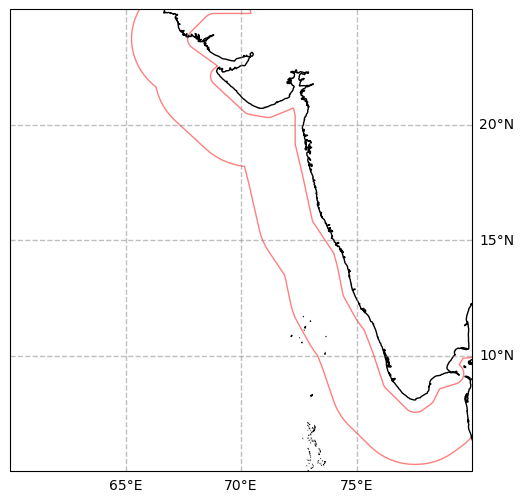

In [119]:
from shapely.geometry import box
import geopandas as gpd
crs = ccrs.PlateCarree()

coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select India coastline
india_coastline = coastline[coastline['name'] == 'India']

# Convert the CRS to UTM zone 43N
# india_coastline_utm = india_coastline.to_crs('EPSG:32643')

distances = [50000, 300000]
buffered = []

# Define bounding box and convert to a GeoDataFrame
bbox = Polygon([(lons.start, lats.start), (lons.start, lats.stop), (lons.stop, lats.stop), (lons.stop, lats.start)])
bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
bbox_gdf.set_crs('EPSG:4326', inplace=True)
bbox_gdf_utm = bbox_gdf.to_crs('EPSG:32643')

# Clip India's coastline with the bounding box
india_coastline_utm_clipped = gpd.clip(india_coastline_utm, bbox_gdf_utm)

# Create buffered geometries
buffered = []
for distance in distances:
    india_buffer = india_coastline_utm_clipped.buffer(distance)
    buffered.append(india_buffer)

# Convert buffered geometries to a GeoDataFrame and transform to WGS84 CRS
buffered_gdfs = [gpd.GeoDataFrame(gpd.GeoSeries(b), columns=['geometry']) for b in buffered]
buffered_wgs84 = [gdf.to_crs('EPSG:4326') for gdf in buffered_gdfs]

# Unify all buffered geometries
union_buffered = unary_union(buffered)

# Plotting
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lons.start, lons.stop, lats.start, lats.stop], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(int(lons.start), int(lons.stop)+1, 5))   # Set longitude markers every 5 degrees
gl.ylocator = mticker.FixedLocator(range(int(lats.start), int(lats.stop)+1, 5))   # Set latitude markers every 5 degrees

# Plot buffers
for buf in buffered_wgs84:
    for geom in buf.geometry:
        if geom.is_empty:
            continue
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        for polygon in geom.geoms:
            x, y = polygon.exterior.coords.xy
            coords = np.column_stack((x, y))
            mpl_poly = mplPolygon(coords, edgecolor='red', facecolor='none', alpha=0.5)
            ax.add_patch(mpl_poly)

# Set the axes limits to your bounding box
ax.set_xlim([lons.start, lons.stop])
ax.set_ylim([lats.start, lats.stop])

plt.show()

In [120]:
from scipy.spatial import KDTree

# Create a KDTree for efficient nearest neighbour search
coords = df_raw[['lon', 'lat']].values
tree = KDTree(coords)

def find_nearest_sst(point, tree, df):
    lon, lat = point.x.values[0], point.y.values[0]
    _, idx = tree.query(np.array([lon, lat]), k=1)
    nearest_sst = df.iloc[idx]['analysed_sst']
    return nearest_sst

In [176]:
def plot_sst(df, upwelling_pairs):
    # Reshape data into 2D for the SST plot
    data = df.pivot(index='lat', columns='lon', values='analysed_sst').copy()

    # Truncate SST data to range 300.0 - 304.0
    data[data < 300.0] = 300.0
    data[data > 304.0] = 304.0
    
    # Create SST plot
    plt.figure(figsize=(10, 6))
    plt.contourf(data.columns, data.index, data.values, cmap='RdYlBu_r', levels=np.arange(300, 304.1, 0.1))
    plt.colorbar(label='SST')

    # Mark locations of upwelling
    for pair in upwelling_pairs:
        point_100km, point_300km = pair
        plt.plot([point_100km.x.values[0], point_300km.x.values[0]], 
                 [point_100km.y.values[0], point_300km.y.values[0]], 
                 color='k')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Sea Surface Temperature and Upwelling Locations')
    plt.show()

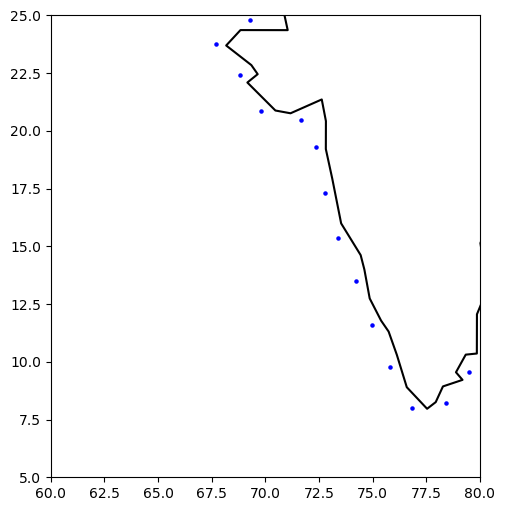

In [154]:
import geopandas as gpd
from shapely.geometry import LineString, Point

# Find the points in the 100km buffer
def sample_points(buffer_gdf, dist):
    sampled_points = gpd.GeoDataFrame(columns=['geometry'])

    for geom in buffer_gdf.geometry:
        boundary = geom.boundary
        length = boundary.length
        num_points = int(length / dist)
        for i in range(num_points):
            fraction = i / num_points

            point = boundary.interpolate(fraction, normalized=True)

            sampled_points.loc[len(sampled_points)] = Point(point)

    return sampled_points

temp = 2
sampled_points_100km = sample_points(buffered_wgs84[0], temp)

# Remove points (noises) with lat = 25 and lon = 80
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y == 25) | 
                                              (sampled_points_100km.geometry.x == 80))]

fig, ax = plt.subplots()
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
india_coastline_wgs84.boundary.plot(ax=ax, color='black')
plt.xlim([60, 80])
plt.ylim([5, 25])

plt.show()

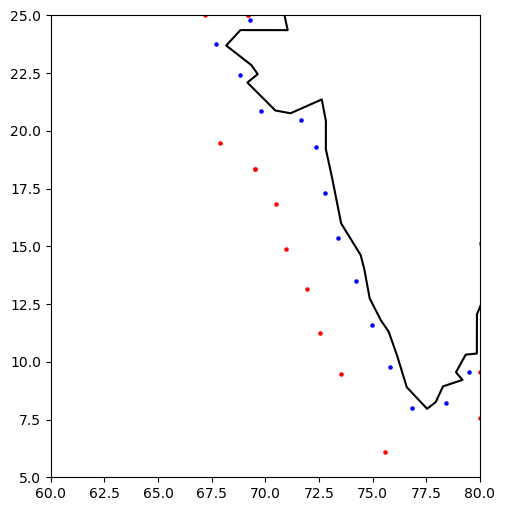

In [166]:
from shapely.ops import nearest_points

def sample_boundary(buffer_gdf, dist):
    sampled_points = gpd.GeoDataFrame(columns=['geometry'])

    for geom in buffer_gdf.geometry:
        boundary = geom.boundary
        length = boundary.length
        num_points = int(length / dist)
        for i in range(num_points):
            fraction = i / num_points
            point = boundary.interpolate(fraction, normalized=True)
            sampled_points.loc[len(sampled_points)] = Point(point)

    return sampled_points

# Generate points along the 300km buffer boundary
sampled_points_boundary_300km = sample_boundary(clipped_buffer_300km, temp)

# Now find nearest points to the 100km points
nearest_points_300km = get_nearest_points(sampled_points_100km, sampled_points_boundary_300km)

# Plotting for visual check
fig, ax = plt.subplots()
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
nearest_points_300km.plot(ax=ax, color='red', markersize=5)
india_coastline_wgs84.boundary.plot(ax=ax, color='black')

plt.xlim([60, 80])
plt.ylim([5, 25])

plt.show()

In [173]:
from shapely.ops import nearest_points

# Function to get nearest points with filter conditions
def get_nearest_points(source_points, candidate_points):
    nearest_points = gpd.GeoDataFrame(columns=['geometry'])
    
    for source_point in source_points.geometry:
        valid_candidate_points = candidate_points.copy()
        
        while True:
            # Compute distances from source_point to all valid_candidate_points
            distances = valid_candidate_points.distance(source_point)
            
            # Find the index of the nearest point
            nearest_point_index = distances.idxmin()

            nearest_point = valid_candidate_points.loc[nearest_point_index]

            # Check if the nearest point is on the bounding box edge or already in nearest_points
            if nearest_point.geometry.y == 25 or nearest_point.geometry.x == 80 or nearest_point.geometry.equals(nearest_points['geometry']).any():
                # If yes, remove it from the valid_candidate_points and recompute
                valid_candidate_points = valid_candidate_points.drop(nearest_point_index)
            else:
                # If not, it's our desired nearest point
                nearest_points.loc[len(nearest_points)] = nearest_point
                break
    
    return nearest_points

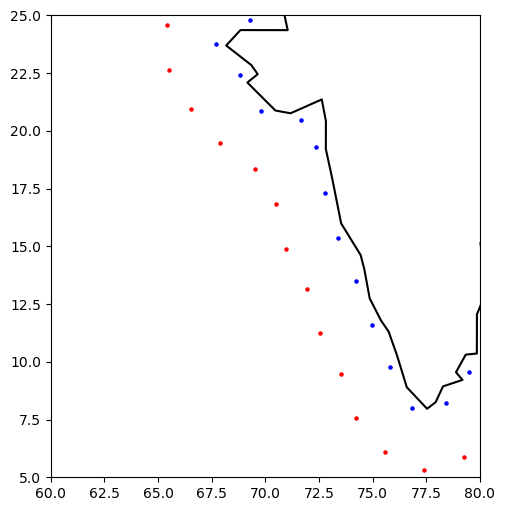

In [186]:
# Function to sample points along the 300km buffer correlated to points on the 100km buffer
def sample_boundary(buffer_gdf, dist):
    sampled_points = gpd.GeoDataFrame(columns=['geometry', 'index'])

    for geom in buffer_gdf.geometry:
        boundary = geom.boundary
        length = boundary.length
        num_points = int(length / dist)
        for i in range(num_points):
            fraction = i / num_points
            point = boundary.interpolate(fraction, normalized=True)
            sampled_points.loc[len(sampled_points)] = {'geometry': Point(point), 'index': i}

    return sampled_points

# Generate points along the 300km buffer boundary
sampled_points_boundary_300km = sample_boundary(clipped_buffer_300km, temp)

# Now find nearest points to the 100km points
nearest_points_300km = get_nearest_points(sampled_points_100km, sampled_points_boundary_300km)
sampled_points_100km = sampled_points_100km.reset_index(drop=True)

# Plotting for visual check
fig, ax = plt.subplots()
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
nearest_points_300km.plot(ax=ax, color='red', markersize=5)
india_coastline_wgs84.boundary.plot(ax=ax, color='black')

plt.xlim([60, 80])
plt.ylim([5, 25])

plt.show()

In [175]:
print(sampled_points_100km)
print(nearest_points_300km)

                     geometry
0   POINT (67.69511 23.76151)
1   POINT (69.29475 24.80920)
14   POINT (79.50390 9.54358)
15   POINT (78.43778 8.23508)
16   POINT (76.84130 8.01849)
17   POINT (75.83044 9.75458)
18  POINT (74.96895 11.60874)
19  POINT (74.24121 13.51252)
20  POINT (73.39835 15.35966)
21  POINT (72.77470 17.29713)
22  POINT (72.34563 19.31007)
23  POINT (71.67743 20.47237)
24  POINT (69.80775 20.85921)
25  POINT (68.82554 22.40976)
                     geometry
0   POINT (65.41760 24.58975)
1   POINT (65.51156 22.62816)
2    POINT (79.27092 5.87254)
3    POINT (77.38331 5.29457)
4    POINT (75.57845 6.08802)
5    POINT (73.52397 9.46200)
6   POINT (72.56575 11.22870)
7   POINT (71.96434 13.14054)
8   POINT (70.98711 14.88477)
9   POINT (70.47880 16.83389)
10  POINT (69.54270 18.32605)
11  POINT (67.90682 19.47132)
12  POINT (66.55836 20.95450)
13   POINT (74.21885 7.56995)


In [202]:
print(nearest_points_300km.loc[0].geometry)


POINT (65.41760292335437 24.589748147578852)


In [206]:
def find_nearest_sst(point, tree, df):
    lon, lat = point.x, point.y
    _, idx = tree.query(np.array([lon, lat]), k=1)
    nearest_sst = df.iloc[idx]['analysed_sst']
    return nearest_sst

threshold = 0.15
df_raw['time'] = pd.to_datetime(df_raw['time'])
grouped = df_raw.groupby(df_raw['time'].dt.date)

# Group the data by day
for date, group in grouped:
    coords = group[['lon', 'lat']].values
    tree = KDTree(coords)
    
    for idx in sampled_points_100km.index:
        point_100km = sampled_points_100km.loc[idx].geometry
        point_300km = nearest_points_300km.loc[idx].geometry

        # Fetch SST values from KDTree for these points
        sst_100km = find_nearest_sst(point_100km, tree, group)
        sst_300km = find_nearest_sst(point_300km, tree, group)

        if abs(sst_100km - sst_300km) > threshold:
            print(f"Upwelling detected at {point_100km} on {date} with sst diff of {abs(sst_100km - sst_300km)}")


Upwelling detected at POINT (67.69511324960968 23.76150983597882) on 2021-07-01 with sst diff of 1.052978515625
Upwelling detected at POINT (79.50389915516581 9.54357965338603) on 2021-07-01 with sst diff of 1.006011962890625
Upwelling detected at POINT (78.4377812774539 8.235080490828693) on 2021-07-01 with sst diff of 0.558013916015625
Upwelling detected at POINT (76.84129739558836 8.018486088595784) on 2021-07-01 with sst diff of 1.13800048828125
Upwelling detected at POINT (75.8304394710054 9.754582170891862) on 2021-07-01 with sst diff of 0.529022216796875
Upwelling detected at POINT (74.24120686947386 13.512524192369613) on 2021-07-01 with sst diff of 0.50201416015625
Upwelling detected at POINT (73.3983478224544 15.359657537021024) on 2021-07-01 with sst diff of 0.157012939453125
Upwelling detected at POINT (72.77470048029625 17.297131109292344) on 2021-07-01 with sst diff of 0.4580078125
Upwelling detected at POINT (72.34563233055425 19.310072889427904) on 2021-07-01 with sst d

In [29]:
def plot_sst(df, upwelling_pairs):
    # Reshape data into 2D for the SST plot
    data = df.pivot(index='lat', columns='lon', values='analysed_sst').copy()

    # Truncate SST data to range 300.0 - 304.0
    data[data < 300.0] = 300.0
    data[data > 304.0] = 304.0
    
    # Create SST plot
    plt.figure(figsize=(10, 6))
    plt.contourf(data.columns, data.index, data.values, cmap='RdYlBu_r', levels=np.arange(300, 304.1, 0.1))
    plt.colorbar(label='SST')

    # Mark locations of upwelling
    for pair in upwelling_pairs:
        point_100km, point_300km = pair
        plt.plot([point_100km[0], point_300km[0]], 
                 [point_100km[1], point_300km[1]], 
                 color='k')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Sea Surface Temperature and Upwelling Locations')
    plt.show()